In [1]:
import torch.utils.data
from utils.data import get_data_split
from utils.models import create_video_ResNet
from utils.trainner import train_silence
from utils.model_performance import plot_losses, get_predictions, calculate_metrics

# Config data

In [2]:
BASE_PATH = "../../../datasets/UCF101/UCF-101-Sampled"
EPOCHS = 100
BATCH_SIZE = 4
TRANSFER_LEARNING_RATE = 3e-3
DEVICE = torch.device("cuda" if torch.cuda else "cpu")

# For M1 mac processors.
# DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load data

In [3]:
train_dataset, val_dataset, test_dataset, label_dict = get_data_split(base_path=BASE_PATH, batch_size=BATCH_SIZE, seq_lenght=60, pts_unit="sec", num_workers=4)

In [4]:
label_dict

{0: 'TennisSwing',
 1: 'Fencing',
 2: 'Basketball',
 3: 'Archery',
 4: 'Bowling',
 5: 'BaseballPitch'}

# Transfer Learning

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

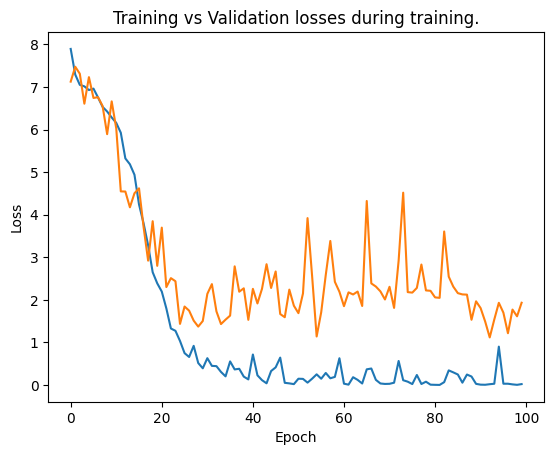

Classification report
               precision    recall  f1-score   support

  TennisSwing       0.94      1.00      0.97        17
      Fencing       0.91      0.91      0.91        11
   Basketball       1.00      0.77      0.87        13
      Archery       1.00      0.93      0.97        15
      Bowling       0.80      1.00      0.89        16
BaseballPitch       0.93      0.87      0.90        15

     accuracy                           0.92        87
    macro avg       0.93      0.91      0.92        87
 weighted avg       0.93      0.92      0.92        87


In [5]:
model, preprocess = create_video_ResNet(n_classes=len(label_dict), device=DEVICE)

model.requires_grad = False
model.fc.requires_grad = True

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=TRANSFER_LEARNING_RATE)

train_loss, val_loss = train_silence(model=model, train_dataset=train_dataset, val_dataset=val_dataset, preprocess=preprocess, device=DEVICE, criterion=criterion, optimizer=optimizer, epochs=EPOCHS, num_classes=len(label_dict))

# load the best weights.
y_pred, y = get_predictions(model=model, dataloader=test_dataset, preprocess=preprocess, device=DEVICE)

plot_losses(train_loss, val_loss)
calculate_metrics(y, y_pred, labels=[v for k,v in label_dict.items()])